In [152]:
# %pip install snscrape
# %pip install demoji

     ---------------------------------------- 42.9/42.9 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [153]:
# se importan las librerias que se van a utilizar

import snscrape.modules.twitter as snt
import pickle
import pandas as pd
import json
import pymysql
from sqlalchemy import create_engine
import re
import demoji
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns
import matplotlib.pyplot as plt


## Tratamiento de los datos

In [43]:
# se importan los ficheros json

with open('data/tweets_2022.json', 'r') as f:
    data = json.load(f)

In [44]:
tweets = data["data"]

In [45]:
# se transforman los datos en un DataFrame
df = pd.DataFrame(tweets)

In [46]:
df.head()

,author_id,created_at,edit_history_tweet_ids,id,public_metrics,text
0,1151510939105144834,2022-12-29T16:39:19.000Z,[1608502937332113408],1608502937332113408,"{'impression_count': 113, 'like_count': 4, 'qu...",Empieza el año formándote en una de las profes...
1,570795448,2022-12-29T12:52:11.000Z,[1608445776732246017],1608445776732246017,"{'impression_count': 124, 'like_count': 2, 'qu...",Los 4 bootcamps tecnológicos de EDEM y @TheBri...
2,1128860148,2022-12-29T09:16:11.000Z,[1608391421014196224],1608391421014196224,"{'impression_count': 49, 'like_count': 2, 'quo...",@EDEMempresarios acoge el 12 de enero un Open ...
3,570795448,2022-12-27T09:00:57.000Z,[1607662809575292929],1607662809575292929,"{'impression_count': 218, 'like_count': 5, 'qu...",Si estás buscando una profesión que te cambie ...
4,1162694149956603904,2022-12-23T12:54:06.000Z,[1606271930763354112],1606271930763354112,"{'impression_count': 120, 'like_count': 1, 'qu...",En @TheBridge_Tech tenemos un deseo para ti💫\n...


In [47]:
# al haber un subconjunto de datos dentro de la columna public_metrics hay que desgranarla.

df["author_id"] = df["author_id"].astype(str)
df["created_at"] = pd.to_datetime(df["created_at"])
df["id"] = df["id"].astype(str)
df["text"] = df["text"].astype(str)
df["impression_count"] = df["public_metrics"].apply(lambda x: x["impression_count"])
df["like_count"] = df["public_metrics"].apply(lambda x: x["like_count"])
df["quote_count"] = df["public_metrics"].apply(lambda x: x["quote_count"])
df["reply_count"] = df["public_metrics"].apply(lambda x: x["reply_count"])
df["retweet_count"] = df["public_metrics"].apply(lambda x: x["retweet_count"])

In [48]:
# se elimina dicha columna ya que hemos extraido los datos que necesitabamos.

df = df.drop(columns=["public_metrics"])

In [49]:
df.head()

,author_id,created_at,edit_history_tweet_ids,id,text,impression_count,like_count,quote_count,reply_count,retweet_count
0,1151510939105144834,2022-12-29 16:39:19+00:00,[1608502937332113408],1608502937332113408,Empieza el año formándote en una de las profes...,113,4,0,0,1
1,570795448,2022-12-29 12:52:11+00:00,[1608445776732246017],1608445776732246017,Los 4 bootcamps tecnológicos de EDEM y @TheBri...,124,2,0,0,0
2,1128860148,2022-12-29 09:16:11+00:00,[1608391421014196224],1608391421014196224,@EDEMempresarios acoge el 12 de enero un Open ...,49,2,0,0,0
3,570795448,2022-12-27 09:00:57+00:00,[1607662809575292929],1607662809575292929,Si estás buscando una profesión que te cambie ...,218,5,0,0,0
4,1162694149956603904,2022-12-23 12:54:06+00:00,[1606271930763354112],1606271930763354112,En @TheBridge_Tech tenemos un deseo para ti💫\n...,120,1,0,0,1


In [165]:
'''el archivo json descargado tambien tenia información del usuario en la parte final, 

asi que se procede a capturar esos datos tambien para el análisis.'''


df_u = pd.DataFrame(data['includes']['users'])

df = df.merge(df_u, left_on='author_id', right_on='id')

df.drop(columns=['id_y'], inplace=True)

df.rename(columns={'id_x':'id_message'}, inplace=True)

df = df[['id_message', 'text', 'created_at', 'author_id', 'name', 'username', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count', 'edit_history_tweet_ids']]

### Se abre el segundo archivo ya que es el que corresponde al año 2023 y se procede exactamente de la misma manera que con el fichero anterior que era de 2022.

In [51]:

with open('data/tweets_2023.json', 'r') as f:
    data_2 = json.load(f)

In [52]:
tweets_2 = data_2["data"]

In [53]:
df_2 = pd.DataFrame(tweets_2)

In [54]:
df_2["author_id"] = df_2["author_id"].astype(str)
df_2["created_at"] = pd.to_datetime(df_2["created_at"])
df_2["id"] = df_2["id"].astype(str)
df_2["text"] = df_2["text"].astype(str)
df_2["impression_count"] = df_2["public_metrics"].apply(lambda x: x["impression_count"])
df_2["like_count"] = df_2["public_metrics"].apply(lambda x: x["like_count"])
df_2["quote_count"] = df_2["public_metrics"].apply(lambda x: x["quote_count"])
df_2["reply_count"] = df_2["public_metrics"].apply(lambda x: x["reply_count"])
df_2["retweet_count"] = df_2["public_metrics"].apply(lambda x: x["retweet_count"])

In [55]:
df_2 = df_2.drop(columns=["public_metrics"])

In [56]:
df_2.head()

,author_id,created_at,edit_history_tweet_ids,id,text,impression_count,like_count,quote_count,reply_count,retweet_count
0,936539844079218688,2023-03-07 17:16:14+00:00,[1633154604018876416],1633154604018876416,¡Hola #dataholics! La primavera trompetera se ...,357,8,1,0,3
1,1585726199485140993,2023-03-06 10:38:30+00:00,[1632692123412594688],1632692123412594688,Las inscripciones se realizarán por Eventbrite...,31,0,0,0,0
2,1585726199485140993,2023-03-06 10:38:30+00:00,[1632692120719859712],1632692120719859712,¡Por fin podemos publicar el cartel con los po...,950,5,1,1,3
3,41545659,2023-03-06 08:48:56+00:00,[1632664546665025536],1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""ML...",90,3,0,0,1
4,925597948410580993,2023-03-04 22:32:56+00:00,[1632147141224275970],1632147141224275970,@nodosenlared @snowded @TheBridge_Tech Muy bue...,35,1,0,0,0


In [57]:
df_2.columns

Index(['author_id', 'created_at', 'edit_history_tweet_ids', 'id', 'text',
       'impression_count', 'like_count', 'quote_count', 'reply_count',
       'retweet_count'],
      dtype='object')

In [58]:
df_u_2 = pd.DataFrame(data_2['includes']['users'])

df_2 = df_2.merge(df_u_2, left_on='author_id', right_on='id')

# df_22.drop(columns=['id_y', 'edit_history_tweet_ids'], inplace=True)
df_2.drop(columns=['id_y'], inplace=True)

df_2.rename(columns={'id_x':'id_message'}, inplace=True)

df_2 = df_2[['id_message', 'text', 'created_at', 'author_id', 'name', 'username', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count', 'edit_history_tweet_ids']]

In [59]:
# se juntan los dos dataframes para despues filtrar

df_total = pd.concat([df, df_2])

In [60]:
df_total.head()

,id_message,text,created_at,author_id,name,username,retweet_count,reply_count,like_count,quote_count,impression_count,edit_history_tweet_ids
0,1608502937332113408,Empieza el año formándote en una de las profes...,2022-12-29 16:39:19+00:00,1151510939105144834,EDEM universitarios,EDEM_uni,1,0,4,0,113,[1608502937332113408]
1,1608445776732246017,Los 4 bootcamps tecnológicos de EDEM y @TheBri...,2022-12-29 12:52:11+00:00,570795448,EDEM,EDEMempresarios,0,0,2,0,124,[1608445776732246017]
2,1607662809575292929,Si estás buscando una profesión que te cambie ...,2022-12-27 09:00:57+00:00,570795448,EDEM,EDEMempresarios,0,0,5,0,218,[1607662809575292929]
3,1605506556123963392,#EDEMpoweredbyTheBridge la revolución formativ...,2022-12-21 10:12:46+00:00,570795448,EDEM,EDEMempresarios,3,0,6,0,329,[1605506556123963392]
4,1608391421014196224,@EDEMempresarios acoge el 12 de enero un Open ...,2022-12-29 09:16:11+00:00,1128860148,Economía 3,Economia_3,0,0,2,0,49,[1608391421014196224]


In [61]:
type(df_total)

pandas.core.frame.DataFrame

### 2. Almacenamiento de los dataframes en base de datos RDS de AWS divididos en 2 tablas.

In [76]:
# datos necesarios para autentificarse 

username = "admin"
password = "admin1234"
host = "database-1.cu0u3prucydd.us-east-1.rds.amazonaws.com" 
port = 3306

In [77]:
# se crea la conexión

db = pymysql.connect(host = host,
                     user = username,
                     password = password,
                     cursorclass = pymysql.cursors.DictCursor
)


cursor = db.cursor()

In [78]:
cursor.execute('SELECT VERSION()')
version = cursor.fetchone()
print(f'MySQL version: {version}')

MySQL version: {'VERSION()': '8.0.28'}


In [65]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 88
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id_message              149 non-null    object             
 1   text                    149 non-null    object             
 2   created_at              149 non-null    datetime64[ns, UTC]
 3   author_id               149 non-null    object             
 4   name                    149 non-null    object             
 5   username                149 non-null    object             
 6   retweet_count           149 non-null    int64              
 7   reply_count             149 non-null    int64              
 8   like_count              149 non-null    int64              
 9   quote_count             149 non-null    int64              
 10  impression_count        149 non-null    int64              
 11  edit_history_tweet_ids  149 non-null    object

In [79]:

# creación de las tablas 

#Select database and create table
use_db = ''' USE tweets_bbdd'''
cursor.execute(use_db)

create_table = '''
CREATE TABLE tweets (
    id_message VARCHAR(250) NOT NULL,
    text TEXT,
    created_at DATETIME,
    author_id TEXT,
    retweet_count INT,
    reply_count INT,
    like_count INT,
    quote_count INT,
    impression_count INT,
    primary key (id_message)
)
'''
cursor.execute(create_table)
db.commit()


In [37]:
# se crea tabla de users_tweet

create_table = '''
CREATE TABLE users_tweet (
    author_id VARCHAR(250) NOT NULL,
    name TEXT,
    username TEXT,
    primary key (author_id)
)
'''
cursor.execute(create_table)
db.commit()

In [79]:
# se usa la base de datos creada anteriormente

cursor.connection.commit()
use_db = ''' USE tweets_bbdd'''
cursor.execute(use_db)

0

In [80]:
# chequear las tablas que tiene la base de datos

cursor.execute('SHOW TABLES')
cursor.fetchall()

[{'Tables_in_tweets_bbdd': 'tweets'}, {'Tables_in_tweets_bbdd': 'users_tweet'}]

In [69]:
# creación de dos dataframes que corresponden a las dos tablas creadas

df_tweets = df[['id_message', 'text', 'created_at', 'author_id', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count']]
df_users = df[['author_id', 'name', 'username']]
df_users.drop_duplicates(subset='author_id', inplace=True)


c:\Users\Bogdan\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
# borrar contenido de la base de datos

# db = pymysql.connect(host = host,
#                     user = username,
#                     password = password,
#                     port = port,
#                     database = "tweets_bbdd",
#                     cursorclass = pymysql.cursors.DictCursor)

# cursor = db.cursor()


# insert_data = '''DELETE FROM tweets'''
# cursor.execute(insert_data)
# # db.commit()

# insert_data = '''DELETE FROM users_tweet'''
# cursor.execute(insert_data)

# db.commit()
# db.close()

In [71]:
# se insertan los datos en las dos tablas creadas en la nube.


cols_tweets = "`,`".join([str(i) for i in df_tweets.columns.tolist()])
cols_users = "`,`".join([str(i) for i in df_users.columns.tolist()])


for i, row in df_tweets.iterrows():
   
    sql = "INSERT INTO `tweets` (`" +cols_tweets + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    # print(sql)
    # print(tuple(row))
    cursor.execute(sql, tuple(row))

    db.commit()

for i, row in df_users.iterrows():
    
    sql = "INSERT INTO `users_tweet` (`" +cols_users + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    # print(sql)
    # print(tuple(row))
    cursor.execute(sql, tuple(row))

    db.commit()
    
    
db.close()

INSERT INTO `tweets` (`id_message`,`text`,`created_at`,`author_id`,`retweet_count`,`reply_count`,`like_count`,`quote_count`,`impression_count`) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
('1608502937332113408', 'Empieza el año formándote en una de las profesiones con más 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯𝗼𝗿𝗮𝗹. ⚠\n\nToma las riendas del 2023 y vente el 12/01 al Open Day donde te contaremos todo sobre los Bootcamps que te cambiarán la vida junto a @TheBridge_Tech. 🤯\n\nhttps://t.co/RnAcI6FUzc', Timestamp('2022-12-29 16:39:19+0000', tz='UTC'), '1151510939105144834', 1, 0, 4, 0, 113)
INSERT INTO `tweets` (`id_message`,`text`,`created_at`,`author_id`,`retweet_count`,`reply_count`,`like_count`,`quote_count`,`impression_count`) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
('1608445776732246017', 'Los 4 bootcamps tecnológicos de EDEM y @TheBridge_Tech en los empleos más demandados 🔝\n\n▶ Data Science\n▶ Desarrollo Web Full Stack\n▶ UX/UI Product Design\n▶ Ciberseguridad\n\nToda la info ⬇\nhttps://t.co/hXDfJnLKPl', Timestamp('2022-1

In [81]:
# leer datos de la tabla para asegurar que se ha realizado como deberia

sql = '''SELECT * FROM tweets'''
cursor.execute(sql)
mi_tabla = cursor.fetchall()
mi_tabla

[{'id_message': '1594964278238654471',
  'text': 'Aprende hoy las profesiones del futuro, ¡inscríbete en el #BBKBootcamp ⏩ https://t.co/uJcCKObkPz\n\nJunto con @TheBridge_Tech podrás aprender sobre Desarrollo Web Full Stack, Data Science, Ciberseguridad y Diseño de producto digital UX UI. https://t.co/wdbmRphsAx',
  'created_at': datetime.datetime(2022, 11, 22, 8, 1, 31),
  'author_id': '702077405045899264',
  'retweet_count': 2,
  'reply_count': 0,
  'like_count': 2,
  'quote_count': 0,
  'impression_count': 0},
 {'id_message': '1594965197613322241',
  'text': 'Ikasi gaur etorkizuneko lanbideak, izena eman #BBKBootcamp -ean ⏩ https://t.co/xvm6ekbcMQ\n\n@TheBridge_Tech -ekin batera,  Full Stack Web Garapena, Data Science, Zibersegurtasuna eta UX UI produktu digitalaren diseinuari buruz ikasteko aukera izango duzu. https://t.co/oxEOX35Osa',
  'created_at': datetime.datetime(2022, 11, 22, 8, 5, 10),
  'author_id': '702077405045899264',
  'retweet_count': 1,
  'reply_count': 0,
  'like_co

In [84]:
pd.DataFrame(mi_tabla).head()

,id_message,text,created_at,author_id,retweet_count,reply_count,like_count,quote_count,impression_count
0,1594964278238654471,"Aprende hoy las profesiones del futuro, ¡inscr...",2022-11-22 08:01:31,702077405045899264,2,0,2,0,0
1,1594965197613322241,"Ikasi gaur etorkizuneko lanbideak, izena eman ...",2022-11-22 08:05:10,702077405045899264,1,0,2,0,0
2,1594968601265586178,Acelerando juntos el #talentodigital en España...,2022-11-22 08:18:42,783248945761910788,1,1,3,0,0
3,1595359906747617280,¡Ven a conocer los BBK bootcamps powered by @T...,2022-11-23 10:13:36,1162694149956603904,4,0,3,0,0
4,1595752907684843520,🔵Acelera tu carrera digital con #BBKBootcamps....,2022-11-24 12:15:15,823470817963032576,3,0,4,0,0


In [85]:
df_total.head()

,id_message,text,created_at,author_id,name,username,retweet_count,reply_count,like_count,quote_count,impression_count,edit_history_tweet_ids
0,1608502937332113408,Empieza el año formándote en una de las profes...,2022-12-29 16:39:19+00:00,1151510939105144834,EDEM universitarios,EDEM_uni,1,0,4,0,113,[1608502937332113408]
1,1608445776732246017,Los 4 bootcamps tecnológicos de EDEM y @TheBri...,2022-12-29 12:52:11+00:00,570795448,EDEM,EDEMempresarios,0,0,2,0,124,[1608445776732246017]
2,1607662809575292929,Si estás buscando una profesión que te cambie ...,2022-12-27 09:00:57+00:00,570795448,EDEM,EDEMempresarios,0,0,5,0,218,[1607662809575292929]
3,1605506556123963392,#EDEMpoweredbyTheBridge la revolución formativ...,2022-12-21 10:12:46+00:00,570795448,EDEM,EDEMempresarios,3,0,6,0,329,[1605506556123963392]
4,1608391421014196224,@EDEMempresarios acoge el 12 de enero un Open ...,2022-12-29 09:16:11+00:00,1128860148,Economía 3,Economia_3,0,0,2,0,49,[1608391421014196224]


## Punto 3.  Realización de análisis

### A. Tweet con mayor repercusión social

In [86]:
df_sorted = df_total.sort_values(['retweet_count', 'like_count'], ascending=False)

In [88]:
# el tweet con mayor repercusion social es de Mario Lopez de Avila
# con 49 retweets y 321 likes

tweet_mas_popular = df_sorted.iloc[0]
tweet_mas_popular

id_message                                              1614612463361695747
text                      Advanced #Cynefin, Estuarine mapping &amp; EUF...
created_at                                        2023-01-15 13:16:23+00:00
author_id                                                          41545659
name                                                   Mario Lopez de Avila
username                                                       nodosenlared
retweet_count                                                            49
reply_count                                                               7
like_count                                                              321
quote_count                                                               4
impression_count                                                     225761
edit_history_tweet_ids                                [1614612463361695747]
Name: 7, dtype: object

### B. El usuario que más menciona a la cuenta

In [99]:
# BBK menciona TheBridge 22 veces

df_total[df_total['text'].str.contains('Bridge')].groupby(['author_id', 'name', 'username'])['id_message'].count().sort_values(ascending=False).head(1)


author_id           name                         username
702077405045899264  Fundación BBK | Obra Social  BBK_eus     22
Name: id_message, dtype: int64

### C. Mes con mas tweets

In [102]:
# el mes de enero es el que mas tweets tiene

df_total.groupby(df_total['created_at'].dt.month)['id_message'].count().sort_values(ascending=False).head(1)

created_at
1    54
Name: id_message, dtype: int64

### D. Palabras más frecuentes


In [106]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
stop_words = set(stopwords.words('spanish'))
palabras_limpia = [word.lower() for text in df_total["text"] for word in word_tokenize(text) if word.lower() not in stop_words and word.isalpha()]

# Contar la frecuencia de cada palabra
palabras_frecuentes = Counter(palabras_limpia)

# Imprimir las palabras más frecuentes
print(palabras_frecuentes.most_common(5))

[('https', 151), ('digital', 32), ('bbkbootcamps', 30), ('bootcamps', 29), ('bbk', 27)]


### E. Correlación matemática entre las métricas publicas

In [110]:
public_metrics = df_total[["retweet_count",	"reply_count", "like_count", "quote_count", "impression_count"]]

In [112]:
correlacion = public_metrics.corr()


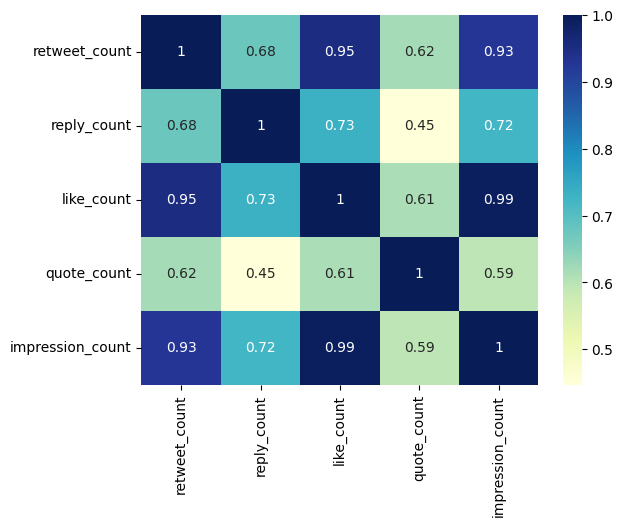

In [113]:
sns.heatmap(correlacion, annot=True, cmap="YlGnBu")
plt.show()

#### Las variables que mas correlación tienen son like y visualización. Es bastante normal que una persona que lo haya visto le guste ya que por lo general las redes sociales muestran contenido personalizado para cada uno, además si sigues una cuenta es porque te gusta el contenido que genera. En segundo lugar tendríamos la correlación de los likes con retweet , que también es algo entendíble. Si te gusta una publicación quieres compartir con otros usuarios ese contenido que te impactó( bien sea positivamente o negativamente). Por el otro lado tenemos las variables que menos correlación tienen que son reply y quote, numero de respuestas que ha recibido un tweet y numero de veces que un tweet ha sido citado o compartido con otros usuarios. Puede deberse a que si un usuario comenta una publicación no sea necesariamente porque quiera también mencionar a alguien, aunque eso podría cambiar si se tratase de un sorteo donde si mencionas a alguien, comentas y das like tienes la posibilidad de ganar un premio.

### F. Conclusiones extra

#### Se podría decir que una red social como twitter está pensada para que los usuarios interaccionen de una forma u otra. No hay ninguna correlación cercana a 0. La mas baja es un 0.45, que si hablamos de correlación fuerte , esta no sería una de ellas pero aún así es bastante significativa ya que los usuarios interactuan con esa variable que se podría decir un 45% de las veces. Esto para una cuenta de cualquier empresa es muy bueno ya que la gente le dedica mas tiempo a su contenido y para posibles o futuras ventas viene muy bien ya que aumenta bastante la posibilidad de conseguir un cliente mas.

## 4. Utilizar modelo ML para determinar el sentimiento de los tweets

In [ ]:
# Lo primero será limpiar los datos y prepararlos para la predicción

In [115]:
Text = df_total[["text"]]
Text

,text
0,Empieza el año formándote en una de las profes...
1,Los 4 bootcamps tecnológicos de EDEM y @TheBri...
2,Si estás buscando una profesión que te cambie ...
3,#EDEMpoweredbyTheBridge la revolución formativ...
4,@EDEMempresarios acoge el 12 de enero un Open ...
...,...
84,¿Quieres dedicarte al #desarrolloweb?\n¡Conéct...
85,🧐 ¿Quieres ser un profesional de la #cibersegu...
86,🤝 @EDEMempresarios se alía con @TheBridge_Tech...
87,¿Quieres desarrollar tu carrera en el mundo di...


In [124]:
df_total["text"].head()

0    Empieza el año formándote en una de las profes...
1    Los 4 bootcamps tecnológicos de EDEM y @TheBri...
2    Si estás buscando una profesión que te cambie ...
3    #EDEMpoweredbyTheBridge la revolución formativ...
4    @EDEMempresarios acoge el 12 de enero un Open ...
Name: text, dtype: object

In [154]:
# Viendo los comentarios que aprecia que las personas son muy dadas a poner emojis en los comentarios.
# Para el fin que tiene este trabajo los emojis son un impedimento a la hora de hacer predicciones así que se eliminan.

demoji.download_codes()

def remove_emojis(text):
    return demoji.replace_with_desc(text, '')

C:\Users\Bogdan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  """Entry point for launching an IPython kernel.


In [155]:
df_total['text'] = df_total['text'].apply(remove_emojis)

In [127]:
# Al igual que los emojis son un impedimento los distintos signos gramaticales lo son también. 
# Vamos a prescindir de ellos

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(\#)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df_total['text'] = df_total['text'].apply(signs_tweets)
df_total['text'].head()

0    empieza el año formándote en una de las profes...
1    los  bootcamps tecnológicos de edem y thebridg...
2    si estás buscando una profesión que te cambie ...
3    edempoweredbythebridge la revolución formativa...
4    edemempresarios acoge el  de enero un open day...
Name: text, dtype: object

In [128]:
# se eliminan links
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df_total['text'] = df_total['text'].apply(remove_links)

In [130]:
# se eliminan las stopwords. palabras que no dicen mucho a un modelo de machine learning.

spanish_stopwords = stopwords.words('spanish')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [133]:
df_total['text'] = df_total['text'].apply(remove_stopwords)
df_total['text'].head()

0    empieza año formándote profesiones 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯...
1    bootcamps tecnológicos edem thebridge_tech emp...
2    si buscando profesión cambie vida acércate ope...
3    edempoweredbythebridge revolución formativa te...
4    edemempresarios acoge enero open day participa...
Name: text, dtype: object

In [135]:
# Se reducen las palabras a su raíz. Vamos a qudarnos solamente con el cuerpo de cada palabra.

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df_total['text'] = df_total['text'].apply(spanish_stemmer)
df_total['text'].head()

0    empiez año formandot profesion 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯𝗼𝗿𝗮𝗹...
1    bootcamps tecnolog edem thebridge_tech emple d...
2    si busc profesion cambi vid acercat open day p...
3    edempoweredbythebridg revolu format tecnologia...
4    edemempresari acog ener open day particip resp...
Name: text, dtype: object

In [137]:
# se carga el modelo 

with open('model/sentiment_model', 'rb') as f:
    modelo_preentrenado = pickle.load(f)

In [138]:
modelo_preentrenado 

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

In [156]:
# se pasa la columna con comentarios a formato lista para poder hacer las predicciones.

comentarios = df_total['text'].tolist()

In [157]:
comentarios

['empiez año formandot profesion 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯𝗼𝗿𝗮𝗹 warning tom riend vent / open day cont bootcamps cambi vid junt thebridge_tech exploding head {link}',
 'bootcamps tecnolog edem thebridge_tech emple demand  play button dat scienc play button desarroll web full stack play button ux/ui product design play button cibersegur tod info down arrow {link}',
 'si busc profesion cambi vid acercat open day present alianz edempoweredbythebridg thebridge_tech seri bootcamps desarroll digital tecnolog {link} {link}',
 'edempoweredbythebridg revolu format tecnologiaexploding head thebridge_tech edem unim form profesion cambi vid especializat bootcamps intens tecnolog \u200d inici cambi  {link} {link}',
 'edemempresari acog ener open day particip respons thebridge_tech edemempresari present bootcamps acerc alumn profesion alta demand {link}',
 'edemempresari thebridge_tech impart bootcamps tecnolog ener form competent digital empleabil demand {link}',
 'thebridge_tech dese ti ¡qu veng carg exit ¡felic

In [158]:


# hacer predicciones en los comentarios
predicciones = modelo_preentrenado.predict(comentarios)

In [159]:
predicciones 

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

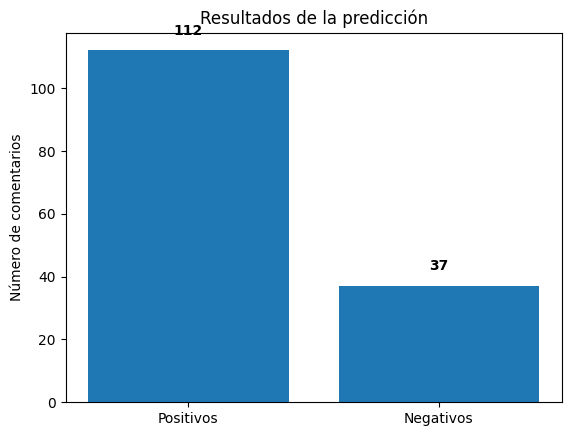

In [168]:
# representación gráfica del resultado de las predicciones

num_positivos = sum(predicciones)
num_negativos = len(predicciones) - num_positivos

fig, ax = plt.subplots()
ax.bar(['Positivos', 'Negativos'], [num_negativos, num_positivos])
ax.set_ylabel('Número de comentarios')
ax.set_title('Resultados de la predicción')

for i, v in enumerate([num_negativos, num_positivos]):
    ax.text(i, v+5, str(v), color='black', ha='center', fontweight='bold')

plt.show()

In [166]:
num_positivos

37